<a href="https://colab.research.google.com/github/kenaimachine/chinesemnist/blob/main/chinesemnistclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Using Chinese Mnist Data

In [1]:
import os
from google.colab import drive
from pathlib import Path
import torch
import torchvision
from torchvision import transforms as transforms
import random
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import shutil
import numpy as np
import cv2

import torch
import torch.nn as nn

**Reminder**

In your google drive folder you will have the following directory structure set up:

(structure is similar if running on local machine)
```
Directory Structure In Google Drive:
MyDrive
|
+-- chinesemnist
     |
     +--data
        |
        +--chinesemnist.csv
        +--model.pth
        +--loss.png
        +--accuracy.png
        |
        +--data
        |  |
        |  +--(original chinese mnist image data)
        |   
        +--selectedData
        |  |
        |  +--(required character images)
        +--modelData
           |
           +--train
           |   |
           |   +--(folder of images by class)
           +--valid
           |   |
           |   +--(folder of images by class)
           +--test
               |
               +--images for testing

```  
* the original data downloaded from kaggle is in
`chinesemnist/data/data`
* data for only the required characters are in `chinesemnist/data/selectedData`
* the split train test set can be found in `chinesemnist/data/modelData`

----

**TO START**

1. Download from Kaggle:
`https://www.kaggle.com/datasets/gpreda/chinese-mnist/download?datasetVersionNumber=7`

2. Copy the folder 'chinesemnist' and upload to Google Dive or your local machine.

3. Copy the `chinesemnistclassification.ipynb` to 'chinesemnist' folder.

4. The creation of other directories and copying of images will be handled programmatically by `chinesemnistclassification.ipynb`.

-----

**HOW TO USE**

1. If you only have uploaded the images as per 'TO START' instruction:
  * Just proceed to run all the jupyter notebook cells in sequential order.
2. If you have already run the code to create all the folders and move the images (essentially complete PART1), you just need to :
    * import the libraries and
    * run 1.Initial Preparation
    * skip everything else from 1.2 to 1.5.
3. If you just wish to adjust the model and retrain the model, you need to:
    * import the libraries
    * run 1.Initial Preparation
    * skip everything else from 1.2 to 1.5.
    * run PART 2 and PART 3. Edit the code as required.
3. If you wish to make only inferences on test data you need to:
    * import the libraries
    * run 1. Initial Preparation
    * And eveything in PART 4.



# PART 1: PROCESSING THE DATA

## 1. Initial Preparation

In [2]:
def checkDirectoryAvailable(root_path):
  if not os.path.exists(root_path):
      os.makedirs(root_path)
      print(f"Directory '{root_path}' created.")

In [3]:
def getRootDir():
    if 'google.colab' in str(get_ipython()):
        # Mount Google Drive in Colab
        from google.colab import drive
        drive.mount('/content/drive')
        root_path= '/content/drive/MyDrive/chinesemnist/data/'  # Set your desired root directory in Google Drive
        checkDirectoryAvailable(root_path)
        return root_path
    else:
        # Set the directory of the Python file
        cwd=os.getcwd()
        # Use the current working directory
        root_path=os.path.join(cwd, 'chinesemnist/data/')
        checkDirectoryAvailable(root_path)
        return root_path

# Get the root directory
root_dir = getRootDir()

print(root_dir)




Mounted at /content/drive
/content/drive/MyDrive/chinesemnist/data/


In [180]:
full_dataset = torchvision.datasets.ImageFolder(root=root_dir )
full_dataset

Dataset ImageFolder
    Number of datapoints: 15000
    Root location: /content/drive/MyDrive/chinesemnist/data/

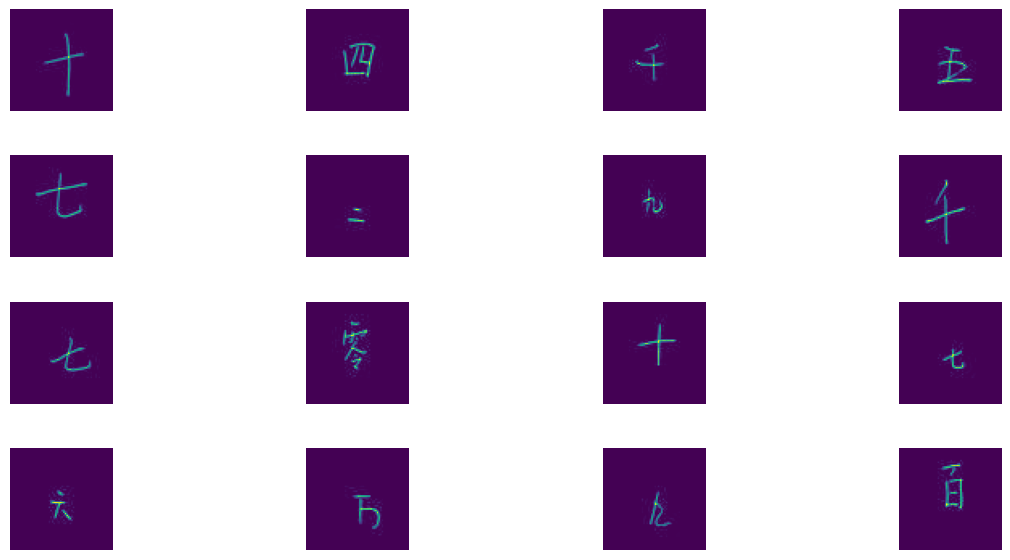

In [181]:
# View the images
image_paths=full_dataset.imgs

fig, axs = plt.subplots(4, 4, figsize=(12, 6))
fig.tight_layout()

for row in axs:
    for col in row:
        img,_=random.choice(image_paths)
        #print(img)
        image=plt.imread(img)
        col.imshow(image)
        col.axis('off')

## 2. Data Cleaning, Data Quality, Data Exploration

In [62]:
#allowed_file(str(next(Path(root_dir+'data/').iterdir())))

### 1.1 Find Total Number Of Images

In [182]:
#check for files that have the right image extensions
ALLOWED_EXTENSIONS = {"jpg", "jpeg", "png", "bmp", "gif", "tiff"}

def allowed_file(filename):
    #print(filename.rsplit('.', 1)[1].lower())
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

In [183]:
def getTotalNumberImages():
  count=0
  #get total number of images
  for imagePath in Path(root_dir+'data/').iterdir():
    #print(imagePath)
    if imagePath.is_file() and allowed_file(str(imagePath)):
      count+=1
      #print('its an image')
  return count

print('Total Number of Images =', getTotalNumberImages())


Total Number of Images = 15000


In [184]:
#Check the size of images and image dimensions
#cannot do this by visual inspection due to 15k number of images.


def checkImageSizeAndChannels(dirPath):
    """get the size of images and image dimensions (ie. the channels).

    Args:
        dirPath (str): the root dir appended with sub-directory holding the data

    Returns:
        pandas dataframe: summary statistics of dataframe with width, height and channels.
    """

  arr=np.empty((0,3))
  for imagePath in tqdm([*Path(dirPath).iterdir()]):
    #get width and height of each image
    img=Image.open(str(imagePath))
    width,height=img.size
    #dim=np.array(img).shape[-1]
    dim=img.mode

    #print(width, height)
    arr=np.append(arr,np.array([[width,height, dim]]),axis=0)

  return pd.DataFrame(arr, columns=['width', 'height', 'channels']).describe(include='all')

checkImageSizeAndChannels(root_dir+'data/')

100%|██████████| 15000/15000 [00:38<00:00, 385.41it/s]


,width,height,channels
count,15000,15000,15000
unique,1,1,1
top,64,64,L
freq,15000,15000,15000


**Summary:**
* 15000 images
* each image size 64x64
* every image is grayscale

### 1.2 Load And Explore chinese_mnist.csv

In [185]:
#get a quick view the chinese_mnist.csv
#read the csv using pandas
data_df=pd.read_csv(root_dir+'chinese_mnist.csv')
data_df.head()



,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [186]:
print(data_df.shape)
data_df.info()


(15000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


#### Descriptive Stats Of Data

In [187]:
data_df.describe()

,suite_id,sample_id,code,value
count,15000.000000,15000.000000,15000.000000,1.500000e+04
mean,50.500000,5.500000,8.000000,6.667410e+06
std,28.867032,2.872377,4.320638,2.494502e+07
min,1.000000,1.000000,1.000000,0.000000e+00
25%,25.750000,3.000000,4.000000,3.000000e+00
50%,50.500000,5.500000,8.000000,7.000000e+00
75%,75.250000,8.000000,12.000000,1.000000e+02
max,100.000000,10.000000,15.000000,1.000000e+08


In [188]:
data_df.describe(include='O')

,character
count,15000
unique,15
top,九
freq,1000


In [189]:
data_df['character'].value_counts()


九    1000
十    1000
百    1000
千    1000
万    1000
亿    1000
零    1000
一    1000
二    1000
三    1000
四    1000
五    1000
六    1000
七    1000
八    1000
Name: character, dtype: int64

#### Check for missing data

In [190]:
data_df.isnull().sum()


suite_id     0
sample_id    0
code         0
value        0
character    0
dtype: int64

### 1.3 Check If Images Matched FilePaths

In [191]:
def createFileName(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name

#add image file name to dataframe
data_df['filename']=data_df.apply(createFileName, axis=1)
data_df.head()

,suite_id,sample_id,code,value,character,filename
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [193]:
data_df.tail()

,suite_id,sample_id,code,value,character,filename
14995,99,5,9,8,八,input_99_5_9.jpg
14996,99,6,9,8,八,input_99_6_9.jpg
14997,99,7,9,8,八,input_99_7_9.jpg
14998,99,8,9,8,八,input_99_8_9.jpg
14999,99,9,9,8,八,input_99_9_9.jpg


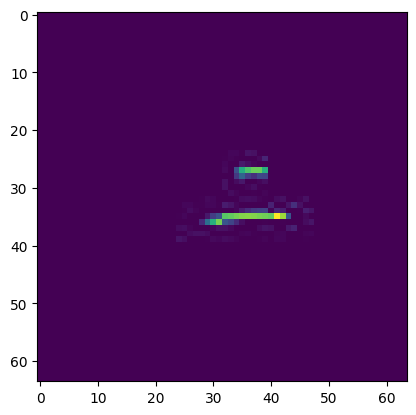

In [192]:
#view a single image file
plt.imshow(plt.imread(root_dir+'data/'+random.choice(data_df['filename'])))

In [194]:
#a quick glimpse into the numpy arrays making up the image.
plt.imread('/content/drive/MyDrive/chinesemnist/data/data/input_1_1_9.jpg')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Random Checking Of Images To Match File Names

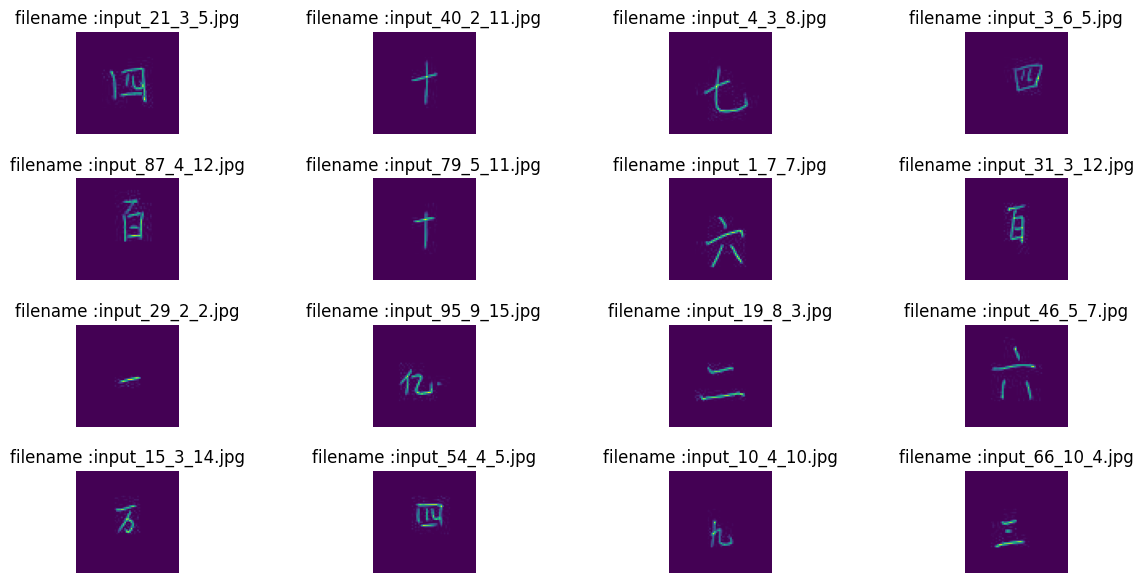

In [195]:
#check if corresponding image is correctly labelled.
#this will be a visual inspection from a randomly selected batch of image files.

fig, axs = plt.subplots(4, 4, figsize=(12, 6))
fig.tight_layout()

for row in axs:
    for col in row:
        f=random.choice(data_df['filename'])
        img=root_dir+'data/'+ f
        image=plt.imread(img)
        col.imshow(image)
        col.set_title(f'filename :{f}')
        col.axis('off')


In [196]:
#select only data relevant for the characters required for classificstion
#drop out those that are not required.
#reform the dataset accordingly

data_df.head()

,suite_id,sample_id,code,value,character,filename
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


### 1.4 Select The Required Characters For Classification From DataFrame

From the given mapping between code and value in the chinese_mnist.csv file, and the requirements from the question, only need to include where value is less than 10.

In [236]:
selected_df= data_df[data_df['value']<10]
selected_df.shape



(10000, 6)

In [237]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   10000 non-null  int64 
 1   sample_id  10000 non-null  int64 
 2   code       10000 non-null  int64 
 3   value      10000 non-null  int64 
 4   character  10000 non-null  object
 5   filename   10000 non-null  object
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


#### Check Distribution Of Characters In Selected Data

In [238]:
selected_df['value'].value_counts()

9    1000
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
Name: value, dtype: int64

Using the subsetted dataframe, create a 'selectedData' folder and move the required files to this folder.



In [239]:
#check if the directory 'selectedData' is available.
#create the directory if neccesary.

def checkDirectoryAvailable():
  if not os.path.exists(root_dir+'selectedData'):
      os.makedirs(root_dir+'selectedData')
      print(f"Directory '{root_dir+'selectedData'}' created.")
  else:
      print(f"Directory '{root_dir+'selectedData'}' already exists.")

In [240]:
checkDirectoryAvailable()

Directory '/content/drive/MyDrive/chinesemnist/data/selectedData' already exists.


In [256]:
def extractRequiredImageFilePath(selectedDF):

    """Using the filtered dataframe create a list of required file paths.

    Args:
        selectedDF (pandas.dataframe): subsetted dataframe for the required training characters.

    Returns:
        list: list of image file paths that are required for training the model.
    """

  imageFilePaths = map(lambda x:(root_dir+'data/'+x, root_dir+'selectedData/'+x),
                       selectedDF['filename'])
  return list(imageFilePaths)

listSelectedFiles=extractRequiredImageFilePath(selected_df)
len(listSelectedFiles)

10000

In [258]:
listSelectedFiles[:5]

[('/content/drive/MyDrive/chinesemnist/data/data/input_1_1_10.jpg',
  '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_1_10.jpg'),
 ('/content/drive/MyDrive/chinesemnist/data/data/input_1_10_10.jpg',
  '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_10_10.jpg'),
 ('/content/drive/MyDrive/chinesemnist/data/data/input_1_2_10.jpg',
  '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_2_10.jpg'),
 ('/content/drive/MyDrive/chinesemnist/data/data/input_1_3_10.jpg',
  '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_3_10.jpg'),
 ('/content/drive/MyDrive/chinesemnist/data/data/input_1_4_10.jpg',
  '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_4_10.jpg')]

#### Copy Required Images To 'selectedData' Folder

In [257]:
for eachFileTuple in tqdm(listSelectedFiles):
    shutil.copy(eachFileTuple[0],eachFileTuple[1])




100%|██████████| 10000/10000 [01:32<00:00, 108.60it/s]


In [259]:
# Check Total Images Copied.
def checkTotalNumberImages(folder):
  count=0
  #get total number of images

  for imagePath in Path(root_dir+folder).iterdir():
    #print(imagePath)
    if imagePath.is_file() and allowed_file(str(imagePath)):
      count+=1
      #print('its an image')
  return count

print('Total Number of Images =', checkTotalNumberImages('selectedData'))

Total Number of Images = 10000


In [260]:
selectedDataFilePaths=[str(eachFile) for eachFile in Path(root_dir+'selectedData').iterdir()]
selectedDataFilePaths[:5]

['/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_1_10.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_10_10.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_2_10.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_3_10.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_1_4_10.jpg']

## Train, Validation, Test Split

From the image files in the 'selectedData', split the image files into train, test and validation folders.


In [261]:
from sklearn.model_selection import train_test_split

# Define the train-test split ratio

test_size = 0.1  # 10% all data for testing
val_size=0.15 #15% of all data is used for validation.
train_size=0.75 #75% of all data for training.

# Perform the train-test split
train_files, test_set = train_test_split(selectedDataFilePaths,
                                           test_size=test_size,
                                           random_state=42)

train_set, val_set = train_test_split(train_files,
                                           test_size=val_size/(1-test_size),
                                           random_state=42)

# Print the number of files in each set
print(f"Number of training files: {len(train_set)}")
print(f"Number of testing files: {len(test_set)}")
print(f"Number of validation files: {len(val_set)}")

Number of training files: 7500
Number of testing files: 1000
Number of validation files: 1500


In [262]:
train_set[:5]

['/content/drive/MyDrive/chinesemnist/data/selectedData/input_25_2_4.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_80_3_1.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_33_3_4.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_34_6_6.jpg',
 '/content/drive/MyDrive/chinesemnist/data/selectedData/input_48_1_2.jpg']

In [273]:
np.array(Image.open(train_set[0])).shape

(64, 64)

In [263]:
def createTrainValTestFolders(listImagePaths, folderName):

  """Copy seleced files to train, test, valid folders.

    Args:
        listImagePaths (list): list of file paths for relevant images.
        folderName (str): folder name required to create.

    Returns:
        None.
  """


  for eachFile in tqdm(listImagePaths):
      try:
        shutil.copy(eachFile,root_dir+'modelData/'+folderName)
      except IOError as e:
        print(str(e))
        os.makedirs(os.path.dirname(root_dir+'modelData/'+folderName))
        print(f'Created {root_dir}'+'modelData/'+folderName)
        shutil.copy(eachFile,root_dir+'modelData/'+folderName)


#### 1.5 Create train, test, vdalidation folders and move the relevant images into them.

In [264]:
createTrainValTestFolders(test_set, 'test/')
print(checkTotalNumberImages('modelData/'+'test/'))


  1%|          | 9/1000 [00:00<00:11, 88.84it/s]

Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/test/
Created /content/drive/MyDrive/chinesemnist/data/modelData/test/


100%|██████████| 1000/1000 [00:10<00:00, 97.60it/s]


1000


In [265]:
createTrainValTestFolders(train_set, 'train/')
print(checkTotalNumberImages('modelData/'+'train/'))

  0%|          | 20/7500 [00:00<01:16, 97.22it/s]

Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/train/
Created /content/drive/MyDrive/chinesemnist/data/modelData/train/


100%|██████████| 7500/7500 [01:38<00:00, 75.93it/s]


7500


In [266]:
createTrainValTestFolders(val_set, 'valid/')
print(checkTotalNumberImages('modelData/'+'valid/'))

  1%|          | 9/1500 [00:00<00:16, 89.72it/s]

Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/
Created /content/drive/MyDrive/chinesemnist/data/modelData/valid/


100%|██████████| 1500/1500 [00:16<00:00, 90.92it/s]


1500


## Move the images into their respective class folders


1. All the images in 'selectedData' folder are images required for the classification of chinese characters from 0 to 9.

2. These are splitted into train, validation and test set - Essentially 3 separate folders.

3. The image filenames is able to indicate the value represented by the image. Using the 'code', represented by the last digit in the filename, it is possible to sort the image files into their respective representive their value.

4. In the next lines of code, the objective is to move all the images to their respective 'class'.

---

**The sample file structure:**
```
selectedData
|
+--train
|  |
|  +--zero
|  |  |
|  |  +--image_1_1_1.jpg
|  |  |
|  |  +--image_2_1_1.jpg
|  |__one
|     |
|     +--image_1_1_2.jpg
|
+--valid
   |
   +--zero
   |
   +--one
   |
   +-- etc...
```

In [274]:

#classDict -> {code:value, ...} (value expressed in text form)
#classDict is use to create the corresponding folder name to hold the images based on its 'code' value.

classDict= {'1':'zero','2':'one', '3':'two',
            '4':'three','5':'four', '6':'five',
            '7':'six', '8':'seven','9':'eight',
            '10':'nine'}

folderDict={'test':'test/','train':'train/','valid':'valid/'}

def moveFilesToClassFolders(classDict, fileNames,folderNames):
  """Identify relevant files in train,test,valid folder and
  move them according to their labels to their respective folders.

    Args:
        classDict (dict): match code value to text for folder label.
        fileNames (list): list of file path in string format.
        folderNames (str): folder name required to create

    Returns:
        count (int): the number of files moved
  """


  count=0
  fn=folderDict.get(folderNames)
  for i in tqdm(fileNames):
    code=i.split('/')[-1].split('.')[0].split('_')[-1]
    #print(code)
    #print(classDict.get(code,'Not Required'))
    #print(root_dir+subdir+'test/'+classDict.get(code,'Not Required')+'/')
    try:
      shutil.move(i,root_dir+subdir+fn+classDict.get(code,'Not Required')+'/')
      count+=count
    except IOError as e:
      print(str(e))
      try:
        os.makedirs(os.path.dirname(root_dir+subdir+fn+classDict.get(code,'Not Required')+'/'))
        print(f'Created {root_dir}+{subdir}+fn+{classDict.get(code,"Not Required")}+"/"')
        shutil.move(i,root_dir+subdir+fn+classDict.get(code,'Not Required')+'/')
        count+=count
      except FileExistsError:
        print('The directory already exists')
  return print(f'Number of Files Moved : {count}')



subdir='modelData/'
fileNames_test=[str(each) for each in Path(root_dir+subdir+'test/').iterdir()]
fileNames_validation=[str(each) for each in Path(root_dir+subdir+'valid/').iterdir()]
fileNames_train=[str(each) for each in Path(root_dir+subdir+'train/').iterdir()]

#moveFilesToClassFolders(classDict,fileNames_test,'test')
moveFilesToClassFolders(classDict,fileNames_validation,'valid')
moveFilesToClassFolders(classDict,fileNames_train, 'train')



  1%|▏         | 20/1500 [00:00<00:15, 95.96it/s]

Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/six/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+six+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/seven/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+seven+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/one/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+one+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/four/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+four+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/zero/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+zero+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/three/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+three+"/"
Directory does not exist: /c

  4%|▍         | 57/1500 [00:00<00:09, 151.78it/s]

Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/valid/nine/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+nine+"/"


100%|██████████| 1500/1500 [00:08<00:00, 184.78it/s]


Number of Files Moved : 0


  0%|          | 8/7500 [00:00<01:53, 65.96it/s]

Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/train/three/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+three+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/train/zero/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+zero+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/train/five/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+five+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/train/one/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+one+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/train/six/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+six+"/"
Directory does not exist: /content/drive/MyDrive/chinesemnist/data/modelData/train/seven/
Created /content/drive/MyDrive/chinesemnist/data/+modelData/+fn+seven+"/"
Directory does not exist: /c

100%|██████████| 7500/7500 [01:00<00:00, 124.21it/s]

Number of Files Moved : 0


# PART 2: PREPARING DATA AND SETTING UP THE MODEL

## Preparing DataLoader

In [42]:

BATCH_SIZE=32

# Define the transformation to apply to the images
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize the images to a specific size
    transforms.Grayscale(),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize the image tensors

])

# Load the training dataset
#By default the imageFolder loads images with 3 channels
#But data is in grayscale (single channel).
#Need to transform
train_dataset = torchvision.datasets.ImageFolder(
    root=root_dir+'modelData/train/',
    transform=transform
)

# Create a data loader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1
)

#This is not required but kept here in case for testing.
# Load the test dataset
# test_dataset = torchvision.datasets.ImageFolder(
#     root=root_dir+'modelData/test/',
#     transform=transform
# )


val_dataset = torchvision.datasets.ImageFolder(
    root=root_dir+'modelData/valid/',
    transform=transform
)

# Create a data loader for the validation dataset
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1
)



#### 2.1 Understanding Dataset and Dataloader

In [43]:
print(f'Classes in train set: {train_dataset.classes}\nNumber of unique classes: {len(set(train_dataset.classes))}\
      Number Of Images: {len(train_dataset)}')
print(f'Classes in validation set: {val_dataset.classes}\nNumber of unique classes: {len(set(val_dataset.classes))}\
      Number Of Images: {len(val_dataset)}')

#print(f'Classes in test set: {test_dataset.classes}\nNumber of unique classes: {len(set(test_dataset.classes))}')



Classes in train set: ['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']
Number of unique classes: 10      Number Of Images: 7500
Classes in validation set: ['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']
Number of unique classes: 10      Number Of Images: 1500


In [44]:
# Check the length of train and test dataloders

print(f"Dataloaders: {train_loader, val_loader}")
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(val_loader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f9e5e37f580>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e8bb76680>)
Length of train dataloader: 235 batches of 32
Length of test dataloader: 47 batches of 32


In [7]:
# Check out what's inside the training dataloader

train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 64, 64]), torch.Size([32]))

In [70]:
#See the class to index matching
#This important to know how pytorch match the different folders to a index value.
#This index value can be thought of as the class label.
#From pytorch documentation, this done through listing the directory and applying sort() to the directory names.

print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)
#print(test_dataset.class_to_idx)

{'eight': 0, 'five': 1, 'four': 2, 'nine': 3, 'one': 4, 'seven': 5, 'six': 6, 'three': 7, 'two': 8, 'zero': 9}
{'eight': 0, 'five': 1, 'four': 2, 'nine': 3, 'one': 4, 'seven': 5, 'six': 6, 'three': 7, 'two': 8, 'zero': 9}


In [10]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
Image shape: torch.Size([1, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


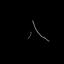

In [317]:
#transforms.ToPILImage()(img).show()

Original shape: torch.Size([1, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 1]) -> [height, width, color_channels]


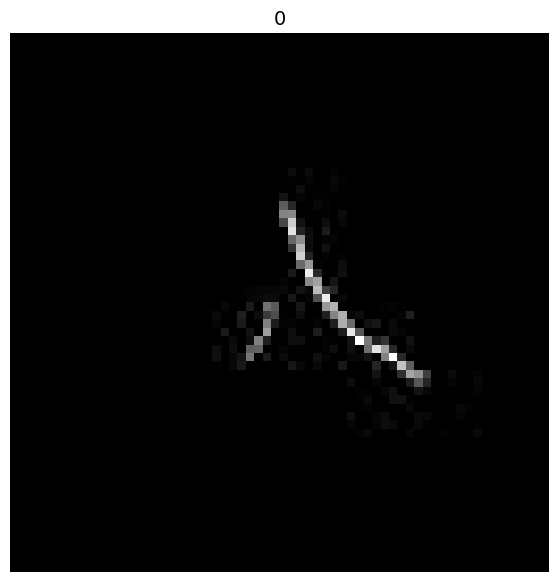

In [11]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.axis("off")
plt.title(label, fontsize=14);

# PART 3: BUILDING AND TRAINING THE MODEL

## Building The Model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:

# Define the CNN model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()

        self.flatten=nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 16 * 32, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x=self.flatten(x)

        #x = x.view(x.size(0), -1) #alternative to flatten layers.
                                  #remove is using nn.Flatten()
        x = self.fc1(x)

        return x

# Create an instance of the ConvNet model
model = ConvNet()

model.to(device)
# Print the model architecture
print(model)




ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
)


In [47]:
next(model.parameters()).device

device(type='cuda', index=0)

In [48]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)






In [49]:
#create a function to time experiments

from timeit import default_timer as timer
def print_train_time(start, end, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [50]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


#### 3.1 Training And Validation Loop

In [51]:
device

'cuda'

In [52]:
# Import tqdm for progress bar
from tqdm import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 60

train_loss_list=[] #list of training loss for plotting later
test_loss_list=[] #list of validation loss for plotting later
val_acc_list=[] #list of validation accuracy scores for plotting later
train_acc_list=[] #list of training accuracy scores for plotting later.

model.to(device)

# Create training and validation loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    train_acc = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_loader):
        model.train()

        X,y=X.to(device),y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        #print(y_pred,y)
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)

        train_loss += loss # accumulatively add up the loss per epoch
        train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
                            #accuracy from prediction labels derived from argmax of logits.

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 100 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)

    train_acc /= len(train_loader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in val_loader:
            X,y=X.to(device),y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(val_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(val_loader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Val loss: {test_loss:.5f},\nTrain acc: {train_acc:.2f}% | Val acc: {test_acc:.2f}%\n")

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    val_acc_list.append(test_acc)
    train_acc_list.append(train_acc)


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


  2%|▏         | 1/60 [00:15<15:25, 15.69s/it]


Train loss: 2.30417 | Val loss: 2.30422,
Train acc: 10.08% | Val acc: 10.54%

Epoch: 1
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


  3%|▎         | 2/60 [00:31<15:11, 15.71s/it]


Train loss: 2.30125 | Val loss: 2.30132,
Train acc: 10.95% | Val acc: 9.91%

Epoch: 2
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


  5%|▌         | 3/60 [00:46<14:42, 15.49s/it]


Train loss: 2.29815 | Val loss: 2.29972,
Train acc: 12.31% | Val acc: 9.24%

Epoch: 3
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


  7%|▋         | 4/60 [01:01<14:20, 15.37s/it]


Train loss: 2.29533 | Val loss: 2.29350,
Train acc: 12.65% | Val acc: 16.73%

Epoch: 4
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


  8%|▊         | 5/60 [01:16<13:57, 15.23s/it]


Train loss: 2.29173 | Val loss: 2.29128,
Train acc: 15.62% | Val acc: 21.15%

Epoch: 5
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 10%|█         | 6/60 [01:31<13:35, 15.11s/it]


Train loss: 2.28709 | Val loss: 2.28622,
Train acc: 18.66% | Val acc: 16.46%

Epoch: 6
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 12%|█▏        | 7/60 [01:46<13:19, 15.09s/it]


Train loss: 2.28217 | Val loss: 2.27919,
Train acc: 22.19% | Val acc: 29.60%

Epoch: 7
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 13%|█▎        | 8/60 [02:01<13:02, 15.05s/it]


Train loss: 2.27593 | Val loss: 2.27532,
Train acc: 27.90% | Val acc: 22.07%

Epoch: 8
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 15%|█▌        | 9/60 [02:16<12:47, 15.05s/it]


Train loss: 2.26913 | Val loss: 2.26787,
Train acc: 27.85% | Val acc: 20.36%

Epoch: 9
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 17%|█▋        | 10/60 [02:31<12:34, 15.09s/it]


Train loss: 2.26159 | Val loss: 2.25839,
Train acc: 32.77% | Val acc: 41.55%

Epoch: 10
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 18%|█▊        | 11/60 [02:46<12:17, 15.06s/it]


Train loss: 2.25178 | Val loss: 2.24770,
Train acc: 34.65% | Val acc: 34.91%

Epoch: 11
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 20%|██        | 12/60 [03:02<12:04, 15.09s/it]


Train loss: 2.24019 | Val loss: 2.23513,
Train acc: 37.05% | Val acc: 37.21%

Epoch: 12
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 22%|██▏       | 13/60 [03:17<11:49, 15.10s/it]


Train loss: 2.22541 | Val loss: 2.21914,
Train acc: 38.50% | Val acc: 40.69%

Epoch: 13
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 23%|██▎       | 14/60 [03:32<11:34, 15.09s/it]


Train loss: 2.20797 | Val loss: 2.19946,
Train acc: 40.89% | Val acc: 44.39%

Epoch: 14
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 25%|██▌       | 15/60 [03:47<11:17, 15.07s/it]


Train loss: 2.18491 | Val loss: 2.17345,
Train acc: 42.88% | Val acc: 45.25%

Epoch: 15
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 27%|██▋       | 16/60 [04:03<11:15, 15.35s/it]


Train loss: 2.15464 | Val loss: 2.14011,
Train acc: 44.03% | Val acc: 44.82%

Epoch: 16
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 28%|██▊       | 17/60 [04:18<10:55, 15.25s/it]


Train loss: 2.11955 | Val loss: 2.10228,
Train acc: 45.70% | Val acc: 45.55%

Epoch: 17
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 30%|███       | 18/60 [04:33<10:36, 15.16s/it]


Train loss: 2.07672 | Val loss: 2.05990,
Train acc: 45.96% | Val acc: 46.91%

Epoch: 18
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 32%|███▏      | 19/60 [04:48<10:19, 15.10s/it]


Train loss: 2.02563 | Val loss: 2.00115,
Train acc: 48.37% | Val acc: 44.49%

Epoch: 19
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 33%|███▎      | 20/60 [05:03<10:02, 15.07s/it]


Train loss: 1.96598 | Val loss: 1.93683,
Train acc: 48.44% | Val acc: 49.95%

Epoch: 20
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 35%|███▌      | 21/60 [05:18<09:46, 15.04s/it]


Train loss: 1.89754 | Val loss: 1.87176,
Train acc: 50.32% | Val acc: 49.56%

Epoch: 21
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 37%|███▋      | 22/60 [05:32<09:27, 14.94s/it]


Train loss: 1.82383 | Val loss: 1.79721,
Train acc: 51.69% | Val acc: 51.22%

Epoch: 22
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 38%|███▊      | 23/60 [05:47<09:11, 14.91s/it]


Train loss: 1.74735 | Val loss: 1.72050,
Train acc: 53.38% | Val acc: 49.93%

Epoch: 23
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 40%|████      | 24/60 [06:02<08:56, 14.90s/it]


Train loss: 1.67192 | Val loss: 1.65333,
Train acc: 54.27% | Val acc: 51.20%

Epoch: 24
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 42%|████▏     | 25/60 [06:17<08:44, 14.99s/it]


Train loss: 1.60146 | Val loss: 1.58002,
Train acc: 55.32% | Val acc: 56.05%

Epoch: 25
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 43%|████▎     | 26/60 [06:33<08:32, 15.07s/it]


Train loss: 1.53514 | Val loss: 1.53327,
Train acc: 56.76% | Val acc: 53.87%

Epoch: 26
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 45%|████▌     | 27/60 [06:48<08:16, 15.04s/it]


Train loss: 1.47626 | Val loss: 1.46398,
Train acc: 57.88% | Val acc: 58.33%

Epoch: 27
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 47%|████▋     | 28/60 [07:03<08:02, 15.08s/it]


Train loss: 1.42391 | Val loss: 1.43755,
Train acc: 58.46% | Val acc: 56.45%

Epoch: 28
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 48%|████▊     | 29/60 [07:18<07:46, 15.05s/it]


Train loss: 1.37994 | Val loss: 1.39828,
Train acc: 59.61% | Val acc: 58.25%

Epoch: 29
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 50%|█████     | 30/60 [07:33<07:31, 15.04s/it]


Train loss: 1.33998 | Val loss: 1.36626,
Train acc: 60.31% | Val acc: 57.17%

Epoch: 30
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 52%|█████▏    | 31/60 [07:48<07:20, 15.20s/it]


Train loss: 1.30742 | Val loss: 1.32530,
Train acc: 60.95% | Val acc: 58.83%

Epoch: 31
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 53%|█████▎    | 32/60 [08:03<07:03, 15.13s/it]


Train loss: 1.27642 | Val loss: 1.33639,
Train acc: 61.82% | Val acc: 57.13%

Epoch: 32
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 55%|█████▌    | 33/60 [08:18<06:48, 15.12s/it]


Train loss: 1.24864 | Val loss: 1.26654,
Train acc: 62.29% | Val acc: 60.00%

Epoch: 33
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 57%|█████▋    | 34/60 [08:33<06:30, 15.04s/it]


Train loss: 1.22107 | Val loss: 1.25316,
Train acc: 63.18% | Val acc: 61.25%

Epoch: 34
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 58%|█████▊    | 35/60 [08:48<06:15, 15.04s/it]


Train loss: 1.19690 | Val loss: 1.21936,
Train acc: 64.00% | Val acc: 62.63%

Epoch: 35
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 60%|██████    | 36/60 [09:04<06:03, 15.13s/it]


Train loss: 1.17607 | Val loss: 1.21537,
Train acc: 64.21% | Val acc: 62.01%

Epoch: 36
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 62%|██████▏   | 37/60 [09:19<05:48, 15.17s/it]


Train loss: 1.15716 | Val loss: 1.20465,
Train acc: 64.61% | Val acc: 61.94%

Epoch: 37
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 63%|██████▎   | 38/60 [09:34<05:32, 15.12s/it]


Train loss: 1.13892 | Val loss: 1.19145,
Train acc: 65.39% | Val acc: 63.16%

Epoch: 38
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 65%|██████▌   | 39/60 [09:55<05:53, 16.85s/it]


Train loss: 1.12060 | Val loss: 1.16552,
Train acc: 65.83% | Val acc: 64.49%

Epoch: 39
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 67%|██████▋   | 40/60 [10:10<05:26, 16.32s/it]


Train loss: 1.10455 | Val loss: 1.15190,
Train acc: 66.13% | Val acc: 64.77%

Epoch: 40
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 68%|██████▊   | 41/60 [10:25<05:01, 15.89s/it]


Train loss: 1.08891 | Val loss: 1.14592,
Train acc: 66.67% | Val acc: 65.09%

Epoch: 41
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 70%|███████   | 42/60 [10:40<04:41, 15.62s/it]


Train loss: 1.07690 | Val loss: 1.15494,
Train acc: 66.77% | Val acc: 64.43%

Epoch: 42
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 72%|███████▏  | 43/60 [10:55<04:21, 15.38s/it]


Train loss: 1.05959 | Val loss: 1.10987,
Train acc: 67.47% | Val acc: 66.60%

Epoch: 43
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 73%|███████▎  | 44/60 [11:09<04:03, 15.25s/it]


Train loss: 1.04711 | Val loss: 1.10029,
Train acc: 68.09% | Val acc: 66.95%

Epoch: 44
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 75%|███████▌  | 45/60 [11:27<03:58, 15.91s/it]


Train loss: 1.03542 | Val loss: 1.10070,
Train acc: 68.12% | Val acc: 66.55%

Epoch: 45
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 77%|███████▋  | 46/60 [11:43<03:42, 15.91s/it]


Train loss: 1.02066 | Val loss: 1.07757,
Train acc: 68.29% | Val acc: 66.29%

Epoch: 46
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 78%|███████▊  | 47/60 [11:58<03:25, 15.78s/it]


Train loss: 1.00987 | Val loss: 1.06136,
Train acc: 69.07% | Val acc: 67.48%

Epoch: 47
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 80%|████████  | 48/60 [12:16<03:16, 16.41s/it]


Train loss: 0.99574 | Val loss: 1.05782,
Train acc: 69.45% | Val acc: 68.08%

Epoch: 48
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 82%|████████▏ | 49/60 [12:33<03:02, 16.62s/it]


Train loss: 0.98319 | Val loss: 1.04366,
Train acc: 70.23% | Val acc: 68.67%

Epoch: 49
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 83%|████████▎ | 50/60 [12:50<02:46, 16.61s/it]


Train loss: 0.96852 | Val loss: 1.03906,
Train acc: 70.23% | Val acc: 68.00%

Epoch: 50
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 85%|████████▌ | 51/60 [13:05<02:24, 16.09s/it]


Train loss: 0.95853 | Val loss: 1.02983,
Train acc: 70.36% | Val acc: 68.60%

Epoch: 51
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 87%|████████▋ | 52/60 [13:20<02:05, 15.72s/it]


Train loss: 0.94601 | Val loss: 1.01242,
Train acc: 70.91% | Val acc: 69.73%

Epoch: 52
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 88%|████████▊ | 53/60 [13:34<01:48, 15.46s/it]


Train loss: 0.93207 | Val loss: 0.99821,
Train acc: 71.22% | Val acc: 70.00%

Epoch: 53
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 90%|█████████ | 54/60 [13:49<01:31, 15.27s/it]


Train loss: 0.92367 | Val loss: 0.98397,
Train acc: 71.94% | Val acc: 70.93%

Epoch: 54
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 92%|█████████▏| 55/60 [14:04<01:15, 15.15s/it]


Train loss: 0.90884 | Val loss: 1.00012,
Train acc: 71.99% | Val acc: 70.28%

Epoch: 55
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 93%|█████████▎| 56/60 [14:19<01:00, 15.09s/it]


Train loss: 0.89340 | Val loss: 0.96080,
Train acc: 72.80% | Val acc: 70.80%

Epoch: 56
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 95%|█████████▌| 57/60 [14:34<00:45, 15.16s/it]


Train loss: 0.88233 | Val loss: 0.95832,
Train acc: 73.17% | Val acc: 71.35%

Epoch: 57
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 97%|█████████▋| 58/60 [14:49<00:30, 15.09s/it]


Train loss: 0.87136 | Val loss: 0.93910,
Train acc: 73.58% | Val acc: 72.06%

Epoch: 58
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


 98%|█████████▊| 59/60 [15:05<00:15, 15.17s/it]


Train loss: 0.85592 | Val loss: 0.93187,
Train acc: 74.13% | Val acc: 71.73%

Epoch: 59
-------
Looked at 0/7500 samples
Looked at 3200/7500 samples
Looked at 6400/7500 samples


100%|██████████| 60/60 [15:20<00:00, 15.33s/it]


Train loss: 0.84312 | Val loss: 0.91775,
Train acc: 74.37% | Val acc: 72.13%

Train time on cuda:0: 920.102 seconds


### 3.2 Accuracy And Loss Graphs

In [63]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(root_dir+'accuracy.png')

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(root_dir+'loss.png')

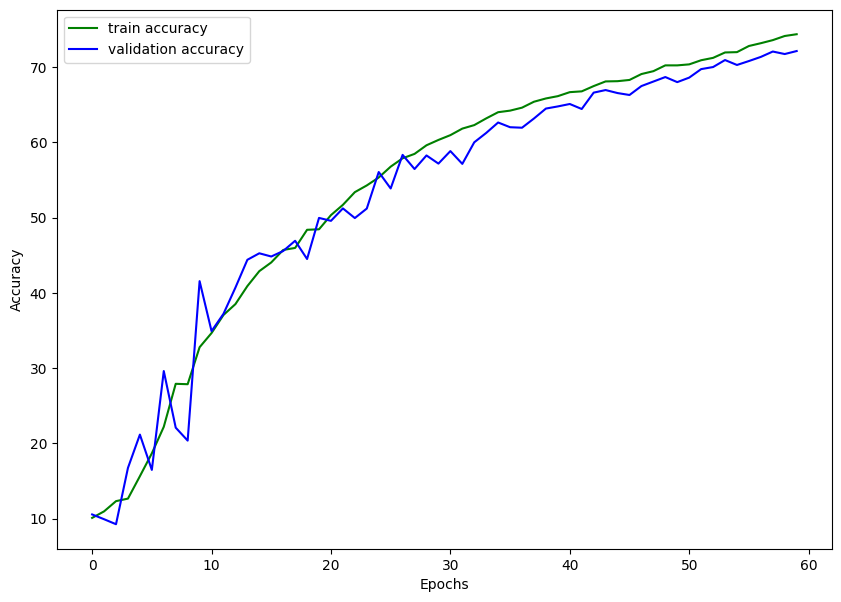

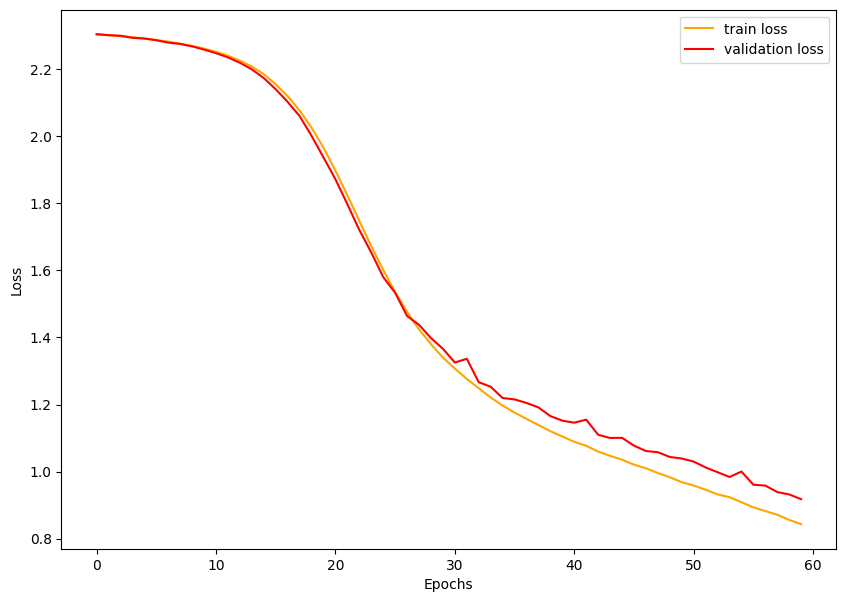

In [64]:
save_plots(train_acc_list,
           val_acc_list,
           [i.to('cpu').detach().numpy() for i in train_loss_list],
           [i.to('cpu').detach().numpy() for i in test_loss_list])

### 3.3 Saving The Model

In [57]:
def save_model(epochs, model, optimizer, loss_fn):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                },
               root_dir+'model.pth')


save_model(epochs, model, optimizer, loss_fn)

#PART4 : MAKING INFERENCES FROM THE MODEL

### 4.1 Loading The Model

In [28]:
#The CNN model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()

        self.flatten=nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 16 * 32, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x=self.flatten(x)

        #x = x.view(x.size(0), -1) #alternative to flatten layers.
                                  #remove is using nn.Flatten()
        x = self.fc1(x)

        return x

In [37]:
# Load your model
model = ConvNet()
#model.load_state_dict(torch.load(root_dir+'model.pth'))

model.load_state_dict(torch.load(root_dir+'model.pth')['model_state_dict'])
model.to(device)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=10, bias=True)
)

### 4.2 Making Predictions On Unseen Test Set

In [80]:
# This code below is to illustrate how Pytorch Dataset creates index to match the folder labels

# classLst=['one','two','three','four','five','six','seven','eight','nine']
# classLst.sort()
# classLst


['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two']

In [38]:
def loadTestFiles(testFolderPath):
  """Extract and return list of file paths in list form

    Args:
        testFolderPath (str): User input the full path to test folder.

    Returns:
        list: list of image file paths for each test image.
    """

  fileNames_test=[str(each) for each in Path(testFolderPath).iterdir()]
  return fileNames_test

testFolderPath=root_dir+'modelData/test/'

test_data=loadTestFiles(testFolderPath)
print(f'Number Of Test Data Available :{len(test_data)}')

Number Of Test Data Available :1000


In [39]:
#classtoIdxMatch={'eight': 0, 'five': 1, 'four': 2, 'nine': 3, 'one': 4, 'seven': 5, 'six': 6, 'three': 7, 'two': 8, 'zero': 9}

classtoIdxMatch={8: 0, 5: 1, 4: 2, 9: 3, 1: 4, 7: 5, 6: 6, 3: 7, 2: 8, 0: 9} #{Actual_value:pred_label}


transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize the images to a specific size
    transforms.Grayscale(),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize the image tensors
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image tensors
])


#Load the test dataset
# test_dataset = torchvision.datasets.ImageFolder(
#     root=root_dir+'modelData/test/',
#     transform=transform
# )


def calTestAccuracy(test_data):
  """calculate the accuracy for unseen test data.

    Args:
        test_data (list): list of file paths for relevant images.
        folderName (str): folder name required to create.

    Returns:
        None.
  """


  model.eval()
  accuratePredict_count=0
  totalPredictions=len(test_data)
  pred_result=[]
  target_result=[]
  with torch.inference_mode():
      for i in tqdm(test_data):
        code=i.split('/')[-1].split('.')[0].split('_')[-1]
        #print(code)
        # read and preprocess the image
        image=Image.open(i)

        # convert to Grayscale format
        image=ImageOps.grayscale(image)

        sample=transform(image)
        sample = torch.unsqueeze(sample, dim=0).to(device)

        pred_logit=model(sample)
        y_pred=pred_logit.argmax(dim=1)
        #print(code, y_pred)

        #get key from value in dictionary
        y_pred_key = list(filter(lambda x: classtoIdxMatch[x] == y_pred, classtoIdxMatch))[0]
        #print(y_pred_key, int(code)-1)
        if int(y_pred_key)==(int(code)-1):
          #print('Match')
          accuratePredict_count+=1
        pred_result.append(int(y_pred_key))
        target_result.append((int(code)-1))
  print(f'Total Test Samples :{len(test_data)}')
  print(f'\nTest Accuracy :{100*accuratePredict_count/totalPredictions:.2f}%')
  return pred_result,target_result

predictedLabel,targetLabel= calTestAccuracy(test_data)


100%|██████████| 1000/1000 [00:27<00:00, 36.50it/s]

Total Test Samples :1000

Test Accuracy :75.70%


In [101]:
# print(predictedLabel[:10])
# print(targetLabel[:10])

[5, 2, 0, 3, 1, 5, 9, 4, 5, 9]
[5, 3, 0, 3, 3, 5, 9, 4, 5, 9]


### 4.3 Confusion Matrix Of Test Set

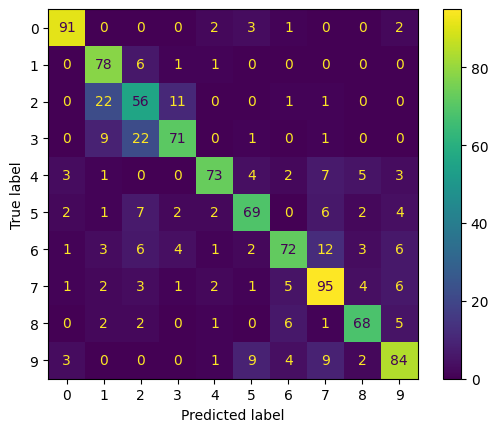

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targetLabel, predictedLabel, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()

In [41]:
from sklearn.metrics import classification_report

print(classification_report(targetLabel, predictedLabel, target_names=['0','1','2','3','4','5','6','7','8','9']))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        99
           1       0.66      0.91      0.76        86
           2       0.55      0.62      0.58        91
           3       0.79      0.68      0.73       104
           4       0.88      0.74      0.81        98
           5       0.78      0.73      0.75        95
           6       0.79      0.65      0.72       110
           7       0.72      0.79      0.75       120
           8       0.81      0.80      0.80        85
           9       0.76      0.75      0.76       112

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



In [59]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

y=targetLabel
pred=predictedLabel
lb = preprocessing.LabelBinarizer()
target=lb.fit_transform(targetLabel)
predicted=lb.transform(predictedLabel)



print(f"ROC_AUC Score: {roc_auc_score(target, predicted, multi_class='ovr'):.2f}")


ROC_AUC Score: 0.87


# PART 5 : OTHERS

## Export Requirements.txt

In [2]:
!pip list --format=freeze > requirements.txt